In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import tflearn, psutil, gc
from datetime import datetime
import h5py
%matplotlib inline

In [2]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [3]:
from rlx.utils import humanbytes
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.35 GB


# We will be creating the same CNN  for classify MNIST as in previous notes

## load the data

In [4]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
mnist = read_data_sets("/tmp/MNIST_data/", one_hot=True, reshape=False, validation_size=0)
print "free mem", humanbytes(psutil.virtual_memory().free)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
free mem 1.11 GB


In [5]:
print mnist.train.images.shape
print mnist.test.images.shape

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# number of images used for training and test
n=10000

idxs = np.random.permutation(range(len(mnist.train.images)))[:n]
train_imgs = mnist.train.images[idxs]
train_ohlabs = mnist.train.labels[idxs]
train_labels = np.r_[[np.argwhere(i)[0][0] for i in train_ohlabs]]

In [7]:
vn = n if n<mnist.test.images.shape[0] else mnist.test.images.shape[0]

idxs = np.random.permutation(range(len(mnist.test.images)))[:n]
test_imgs = mnist.test.images[idxs]
test_ohlabs = mnist.test.labels[idxs]
test_labels = np.r_[[np.argwhere(i)[0][0] for i in test_ohlabs]]

In [8]:
print train_imgs.shape, test_imgs.shape
print "free mem", humanbytes(psutil.virtual_memory().free)

(10000, 28, 28, 1) (10000, 28, 28, 1)
free mem 1.07 GB


In [9]:
del(mnist)
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.27 GB


In [10]:
print pd.Series(train_labels).value_counts()
print pd.Series(test_labels).value_counts()

1    1116
7    1044
0    1033
6    1023
2    1014
3     996
9     989
4     986
8     928
5     871
dtype: int64
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


## use `tflearn` to create network

observe we set `verbose=3` to monitor weights evolution during training

In [42]:
def get_model():
    num_classes = 10

    tf.reset_default_graph()

    network1 = input_data(shape=[None, 28, 28, 1])
    network2 = conv_2d(network1, 9, 5, strides=1, activation='relu', name="conv1", padding="SAME")
    network3 = conv_2d(network2, 18, 4, strides=2, activation='relu', name="conv2", padding="SAME")
    network4 = fully_connected(network3, 100, activation='relu', name='fc1')
    network5 = fully_connected(network4, 10, activation='softmax', name='fc2')
    network6 = regression(network5, optimizer="adam",  loss='categorical_crossentropy')

    model   = tflearn.DNN(network6, tensorboard_verbose=3, tensorboard_dir="log")
    return model

In [52]:
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 820.15 MB


## train from scratch

train with **only 2 epochs**. observe in tensorboard weight evolutions all layers, specially the convolutional ones

In [49]:
model = get_model()

In [50]:
model_name = "tflearn_cnn_mnist_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
print "model name", model_name
model.fit(train_imgs, train_ohlabs, n_epoch=2,  validation_set=(test_imgs, test_ohlabs), shuffle=True,
          show_metric=True, batch_size=100, snapshot_step=10, snapshot_epoch=False, run_id=model_name)

Training Step: 199  | total loss: 0.24346 | time: 65.125s
| Adam | epoch: 002 | loss: 0.24346 - acc: 0.9228 -- iter: 09900/10000
Training Step: 200  | total loss: 0.24208 | time: 70.518s
| Adam | epoch: 002 | loss: 0.24208 - acc: 0.9215 | val_loss: 0.22450 - val_acc: 0.9302 -- iter: 10000/10000
--


(5, 5, 1, 9)


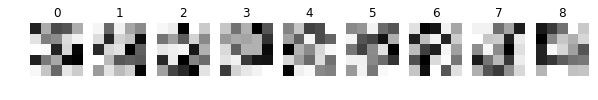

In [51]:
vars = {i.name:i for i in tflearn.variables.get_all_trainable_variable()}
w1 = model.get_weights(vars['conv1/W:0'])
print w1.shape
def display_imgs(w, figsize=(10,3)):
    plt.figure(figsize=figsize)
    for i in range(w.shape[-1]):
        plt.subplot(1,w.shape[-1],i+1)
        plt.imshow(w[:,:,i], cmap = plt.cm.Greys_r, interpolation="none")
        plt.axis("off")
        plt.title(i)

display_imgs(w1[:,:,0,:])

## load and set pretrained weights

In [69]:
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 949.91 MB


In [57]:
with h5py.File('pretrained_models/binmnist.h5','r') as h5f:
    conv1_W = h5f["conv1/W:0"][:]
    conv1_b = h5f["conv1/b:0"][:]
    conv2_W = h5f["conv2/W:0"][:]
    conv2_b = h5f["conv2/b:0"][:]
    fc1_W = h5f["fc1/W:0"][:]
    fc1_b = h5f["fc1/b:0"][:]
    fc2_W = h5f["fc2/W:0"][:]
    fc2_b = h5f["fc2/b:0"][:]

### create model

observe random weights

{u'conv1/W:0': <tf.Variable 'conv1/W:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 u'conv1/b:0': <tf.Variable 'conv1/b:0' shape=(9,) dtype=float32_ref>,
 u'conv2/W:0': <tf.Variable 'conv2/W:0' shape=(4, 4, 9, 18) dtype=float32_ref>,
 u'conv2/b:0': <tf.Variable 'conv2/b:0' shape=(18,) dtype=float32_ref>,
 u'fc1/W:0': <tf.Variable 'fc1/W:0' shape=(3528, 100) dtype=float32_ref>,
 u'fc1/b:0': <tf.Variable 'fc1/b:0' shape=(100,) dtype=float32_ref>,
 u'fc2/W:0': <tf.Variable 'fc2/W:0' shape=(100, 10) dtype=float32_ref>,
 u'fc2/b:0': <tf.Variable 'fc2/b:0' shape=(10,) dtype=float32_ref>}

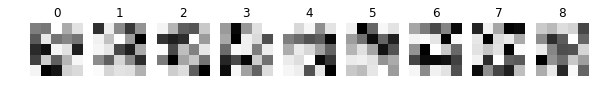

In [63]:
model = get_model()
vars = {i.name:i for i in tflearn.variables.get_all_trainable_variable()}
w1 = model.get_weights(vars['conv1/W:0'])
display_imgs(w1[:,:,0,:])
vars

### load weights

In [64]:
model.set_weights(vars['conv1/W:0'], conv1_W)
model.set_weights(vars['conv1/b:0'], conv1_b)
model.set_weights(vars['conv2/W:0'], conv2_W)
model.set_weights(vars['conv2/b:0'], conv2_b)
model.set_weights(vars['fc1/W:0'], fc1_W)
model.set_weights(vars['fc1/b:0'], fc1_b)

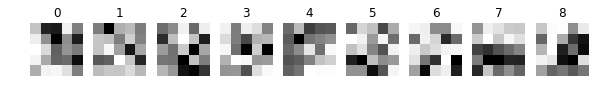

In [65]:
w1 = model.get_weights(vars['conv1/W:0'])
display_imgs(w1[:,:,0,:])

## train and use `tensorboard` to see progress and results

observe:

- accuracy is much better with the same amount of training
- first layer filters have not moved much (both when visualizing filters and in Tensorboard histograms)

In [66]:
model_name = "tflearn_cnn_mnist_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
print "model name", model_name
model.fit(train_imgs, train_ohlabs, n_epoch=2,  validation_set=(test_imgs, test_ohlabs), shuffle=True,
          show_metric=True, batch_size=100, snapshot_step=10, snapshot_epoch=False, run_id=model_name)

Training Step: 199  | total loss: 0.05349 | time: 60.955s
| Adam | epoch: 002 | loss: 0.05349 - acc: 0.9835 -- iter: 09900/10000
Training Step: 200  | total loss: 0.05113 | time: 66.231s
| Adam | epoch: 002 | loss: 0.05113 - acc: 0.9852 | val_loss: 0.07764 - val_acc: 0.9743 -- iter: 10000/10000
--


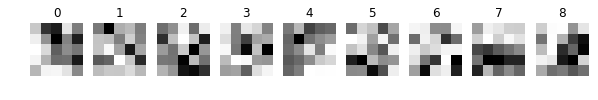

In [67]:
w1 = model.get_weights(vars['conv1/W:0'])
display_imgs(w1[:,:,0,:])

In [68]:
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 700.82 MB
